# Destinations [#audience]

We chose eight of our favorite coffee houese in the Berlin. We chose these because, as Minervans, we spend a lot of time working in different cafes throughout the city, but it can sometimes be hard to find cafe's with good coffee and reliable wifi. So, we thought we could do a service to future generations of Minervans in Berlin by preparing this list and finding the optimal path to visit all of them. We call this the cafe tour.

Berlin is one of the centers in the world's third wave coffee culture. As such, there are many cafes in Berlin that is known for its specialty coffee. The following 8 sites are some of Gordon's favorite coffeee spots in Berlin, in additional to classical Minervan spots. Bonanza Coffee Roasters removed wifi from the site after a previous class occupied the cafe. Milch and Zucher and The Visit has became Minervan's new swarming spots near the residence hall. 

1. The Barn is known for its special drinks, featuring a mix of speciailty coffee beans with interesting ingredients. On top of consistent, high-quality coffees, seasonal specials striking a balance of the taste of the region with the notes of spices, juices and aromatic choices makes The Barn an ideal location for something other than plain coffee. On top of this, this location features a large round table ideal for working.
2. Milch and Zucher -- Leo's comment: I go there because the price is cheap and they don't kick me out. The coffee is mediocre and the music is bad. Nevertheless, the place attracts Minervans due to plugs and free-wifi. The AWS of Berlin.
3. Bonanza Coffee Roasters is located conveniently 1 block away from the original residence hall, the previous epicenter of Minervan swarming. Two years ago, they removed the wifi due to Minervans hogging the place. Nevertheless, the coffee is consistently excellent. This is not a place to study, but rather, sit down and enjoy your cup of coffee. They have a special blend of milk supplied from Brandenburg
4. Five Elephants Kreuzberg  is another fun roastery in Berlin. In addition to top-quality coffee, this location features home-made desserts with excellent cheesecake.
5. The Visit is all-around a nice cafe. Located within a courtyard, the location roasts its own beans and features food during lunch-time. Overall, this is a nice and solid coffee without any imperfections. The location has decent wifi and some tables to sit. Medium frequency of seeing Minervans there.
6. Father Carpenter is excellent in this location. Featuring a Scandinavian light-roast, the place is known for its excellent brunch curation. During summertimes, the courtyard seating within red-brick buildings attracts alot of people. Reservations for brunch are full weeks ahead.
7. Hallesches Haus is another location far away from residence, nevertheless a likeliness of bumping into Minervans. Part cafe, part boutique shops, part art gallery, this spot has its own kitchen with a nice offering of drinks. On weekends Bloody Marries are served for some nice mid-day creativity.
8. Michelberger Hotel is one of Gordon's secret location. Cafe in the morning, bar at night, this is a hotel's lounge with excellent music curation. This location opens to 2 AM, and satisfies all needs from coffee, to food, to late-night drinks. Excellent cocktails to go through late-night classess.

# Travel Times [#evidencebased]

To fully formulate the traveling salesman problem, we needed data on the time required to bike between each pair of cafes. Due to the recent surge in COVID cases, we decided the safest way to collect this data was using Google maps. Many Minervans own bikes in Berlin. So, we thought bike times were probably most relevant to future classes.

Fig. 1 displays a graph of the cafes along with the estimated biking time between each pair.

**Figure 1.** *Cafes with estimated biking times in minutes*

![graph](imgs/graph.png)

# TSP Formulation [#optimizationstrategy, #constrained, #algorithms]

Our goal with this assignment was the find the route from the residence hall through all 8 cafes that takes the minimum time to bike. To do this, we think about the problem as a graph traversal problem---the problem of finding the shortest path through the graph of cafes which visits every cafe. Then, we can formulate this problem as an integer programming problem with a number of constraints.

## Constraints

To formulate this project as an integer programming problem, we need to describe possible routes in terms of integer valued variables. We define a design variables $x_ij$ for each pairs of nodes $i$ and $j$. This design variable takes on the value $1$ if the route goes directly from $i$ to $i$, and it is zero otherwise. We add the constraint:

$$
x_{ij} \in \{0, 1\}
$$

We need to constrain the values of the funtion to ensure that every node it visited at least once. We can do this by adding these contraints:

$$\sum_{i=0}^n x_ij = 1$$
$$\sum_{j=0}^n x_ij = 1$$

These say that the route must enter and leave each node exactly once.

This ensures that the route visits every node exactly once, but it allows for the possibility of subtours. To prevent this, we use black magic. We introduce a new set of integer valued design variables $u_i$ for $i \in \{1..n\}$. Then, we add the following two constraints:

$$u_i > 0$$

And, for all $i, j$ where $i \ne j$:
$$u_i - u_j + nx_{ij} \le n - 1$$

This constraints ensures that no there are no subtours in the final answer.

## Objective

We want to find an expression for the cost of a route desribed by the design variables $x_{ij}$. Let $c_{ij}$ represent the cost of traveling from node $i$ to node $j$ in the network. Then, the cost of the route will be:

$$
cost = \sum_{i, j \in \{1..n\}}x_{ij}c_{ij}
$$

This expression looks at every edge which we could travel and asks if we travel it as part of the route. It adds up the costs of all the routes we take.

# Alternative Strategies

In order to check the accuracy of our solution, we compare this result to an anlysis of the problem using two other optimization methods: ant colony optimization and brute force search.

## Brute Force
Since we are solving the traveling salesman for a case with only 8 cafes, the problem is actually small enough to brute force. There are $8! = 40,302$ distinct paths through all eight cafes, starting and ending at the res hall. So, we can simply iterate over these and see which is cheapest. Obviously, this solution would not scale to larger problems, but for the problem it provides an optimal solution at minimal development cost.

## Ant Colony
The third method we looked at is ant colony optimization. This method is distinct from the other two because it is stochastic; it relies on semi-random exporation of the space of possible routes. It is also a form of swarm intelligence algorithm. Ant colony optimization works by assigning a real-valued "pheromone" value to each edge in the graph. This quantity declines exponentially over time and corresponds to the pheromones deposited by ants when searching for paths while finding food.

The work of the algorithm is done by finding and scoring individual paths through the problem. A path is generated by starting at the res hall and then successively selecting locations to visit. At each step, the probability of moving from the current location $i$ to one of the remaining, unvisited cafes is given by the following proportionality expression.

$$
P(i, j) \propto x_{ij}^\alpha p_{ij}^\beta
$$

Here, $x_{ij}$ denotes the cost of moving from $i$ to $j$, and $p_{ij}$ denotes the level of pheromones on the undirected edge connecting $i$ and $j$. The parameters $\alpha$ and $\beta$ control the relative importance of the pheromone level and the cost in influenceing ant behavior. For our application, we set them both to $1$. To turn this proportionality equation into a distribution, it is summed across all unvisited cafes and normalized.

The algorithm is executed in a series of "batches". In each bath, a fixed number of routes is calculated using the method above (in the code, this number is controlled by the `n_ants` parameter). After all the routes have been calculated, a phermone update is performed for the edges along each route. For each route $r_k$, let $C(r_k)$ denote the total cost of the route. The pheromone level $p_{ij}$ of each edge $e_{ij}$ along the route is updated as follows.

$$
p_{ij} := {q \over C(r_k)}
$$

Here, $q$ is a parameter of the algorithm, which we set to $1$ for this application.

At the end of each batch, the pheromone $p_{ij}$ level of each edge is updated according to the following expression.

$$
p_{ij} := p_{ij}\rho
$$

Here, $\rho$ is a parameter of the model, which we set to $0.99$.

The algorithm is run for a fixed number of batches, and then the best route that has been found so far is returned. The number of batchers is controlled by the `n_batches` parameter in the code.

## Comparison

Among these approaches, the brute force method is the slowest and ant colony is the fastest. The advantage of the brute force method is that is always returns the best solution, and it is easy to program. The integer programming solution also finds the best solution, and it has the advantage that it is easy to feed to fast, special purpose libraries like CVXPY. The execution time of both grows exponentially in the size of the problem, making them intractable for large problems.

The time required to execute the ant colony is largely controlled by the `n_ants` and `n_batches` parameters. A longer run will (probably) lead to better results. However, nothing about the algorithm itself requires that the execution time grow in the size of the problem. For this reason, the ant colony algorithm is the prefered in many real-world applications.

# Optimal Solution [#optimization]



![route comparison](imgs/comparison.png)

![distribution of ac outcomes](imgs/ac_hist.png)

# Appendix: Code

In [1]:
import numpy as np
import random
import networkx as nx
import cvxpy as cp
import matplotlib.pyplot as plt
import itertools

In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
cafes = ['A&O Hostels', 'Bonanza Coffee Roasters', 'Milch and Zucher Oranienstraße', 'The Visit Coffee Roasters', 'Five Elephants Kreuzberg', 'The Barn Cafe Neukölln', 'Michelberger Hotel', 'Father Carpenter', 'Hallesches Haus']
cost = np.array([
    [ 0. ,  4.5,  4. ,  4. , 11. ,  8.5,  9. , 10.5, 13.5],
    [ 4.5,  0. ,  4.5,  4. , 12. ,  9.5, 13. , 15. , 13.5],
    [ 4. ,  4.5,  0. ,  1. ,  8.5,  6. , 12. , 12.5,  8.5],
    [ 4. ,  4. ,  1. ,  0. ,  8. ,  5. , 11.5, 14. ,  9. ],
    [11. , 12. ,  8.5,  8. ,  0. ,  3. ,  9. , 20.5, 15. ],
    [ 8.5,  9.5,  6. ,  5. ,  3. ,  0. , 12. , 19. , 11.5],
    [ 9. , 13. , 12. , 11.5,  9. , 12. ,  0. , 16.5, 19.5],
    [10.5, 15. , 12.5, 14. , 20.5, 19. , 16.5,  0. , 17. ],
    [13.5, 13.5,  8.5,  9. , 15. , 11.5, 19.5, 17. ,  0. ]
])


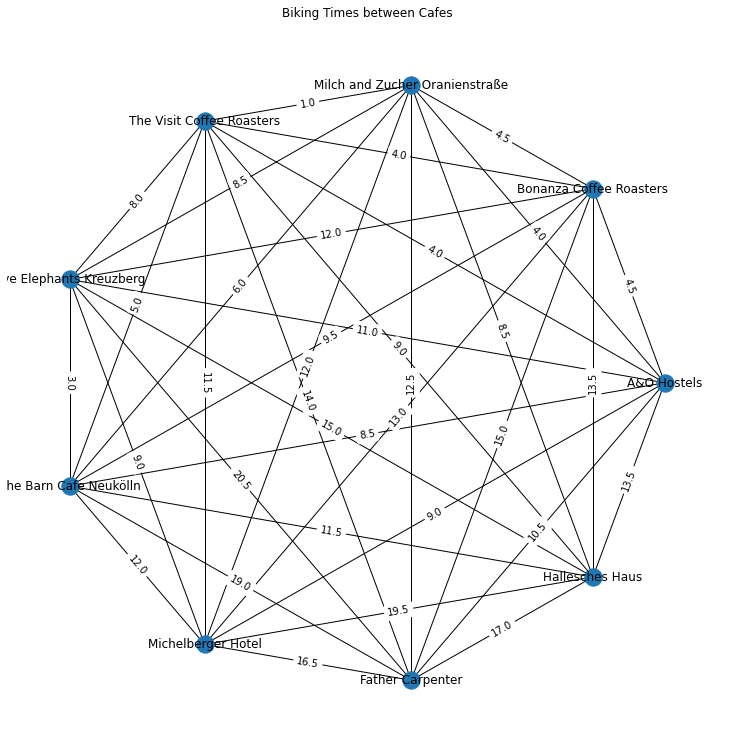

In [4]:
g = nx.from_numpy_array(cost)
g = nx.relabel_nodes(g, dict(enumerate(cafes)))

plt.figure(figsize=(10,10))
pos = nx.circular_layout(g)
nx.draw(g, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'weight'))

plt.title("Biking Times between Cafes")
plt.savefig("imgs/graph.png")

In [5]:
def integer_programming(names, cost):
    """Solves the traveling salesman problem using CVXPY and integer programming."""

    n = cost.shape[0]

    # route matrix
    X = cp.Variable(cost.shape, boolean = True)

    # surrograte variables
    u = cp.Variable(n, integer = True)

    # objective function
    objective = cp.Minimize(cp.sum(cp.multiply(cost, X)))

    #define constraints
    ones = np.ones(n)
    constraints = [
        # each node must be visited exactly once
        X @ ones == ones,
        X.T @ ones == ones,

        # no self-loops
        cp.diag(X) == 0,

        #The first variable is the starting point (A&O Hostels)
        u[0] == 1,
        u[1:] >= 2,
        u[1:] <= n,
    ]

    # subtour elimination constraints
    for i in range(1,n):
        for j in range(1,n):
            if i != j:
                constraints.append(u[i] - u[j] + n*X[i,j] <= n-1)
    
    # Define and solve the CVXPY problem.
    cp.Problem(objective, constraints).solve()

    # convert the result to a list of visited nodes
    next_pos = {}
    for cafe in range(n):
        next_pos[cafe] = np.nonzero(X.value[cafe,:])[0][0]
    
    pos = 0
    next = None

    route = [cafes[pos]]
    route_cost = 0

    while next != 0:
        next = next_pos[pos]
        route_cost += cost[pos, next]
        route.append(cafes[next])
        pos = next

    return route, route_cost

ip_route, ip_cost = integer_programming(cafes, cost)
ip_route, ip_cost

(['A&O Hostels',
  'Father Carpenter',
  'Michelberger Hotel',
  'Five Elephants Kreuzberg',
  'The Barn Cafe Neukölln',
  'Hallesches Haus',
  'Milch and Zucher Oranienstraße',
  'The Visit Coffee Roasters',
  'Bonanza Coffee Roasters',
  'A&O Hostels'],
 68.5)

Long-step dual simplex will be used


In [6]:
def brute_force(cafes, g):
    best_cost = np.inf
    best_route = None

    # iterate over possible routes
    for route in itertools.permutations(cafes[1:]):

        # calculate cost of route
        route_cost = 0
        position = cafes[0]
        for next in list(route) + [cafes[0]]:
            route_cost += g.edges[position, next]["weight"]
            position = next
        
        # check if this is the new winner
        if route_cost < best_cost:
            best_cost = route_cost
            best_route = [cafes[0]] + list(route) + [cafes[0]]
    
    return best_route, best_cost

bf_route, bf_cost = brute_force(cafes, g)
bf_route, bf_cost

(['A&O Hostels',
  'Bonanza Coffee Roasters',
  'The Visit Coffee Roasters',
  'Milch and Zucher Oranienstraße',
  'Hallesches Haus',
  'The Barn Cafe Neukölln',
  'Five Elephants Kreuzberg',
  'Michelberger Hotel',
  'Father Carpenter',
  'A&O Hostels'],
 68.5)

In [7]:
class AntColony:
    def __init__(self, g, start, alpha=1, beta=1, rho=0.99, q=1, n_ants=10, n_batches=10):
        """The ant colony optimization algorithm for the TSP
        
        Args:
            g (networkx.Graph): graph to solve ("weight" attribute carries cost)
            start (Any): starting node
            alpha (float): relative importance of pheromone
            beta (float): relative importance of edge cost
            rho (float): pheromone evaporation factor
            q (float): pheromone deposit factor
            n_ants (int): number of ants per batch
            n_batches (int): number of batches in a run
        """
        self.g = g
        self.start = start

        # optimization parameters
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q

        # length of run
        self.n_ants = n_ants
        self.n_batches = n_batches

        # best found route
        self.best_route = None
        self.best_cost = np.inf

        # initialize pheromones
        for edge in self.g.edges:
            self.g.edges[edge]["pheromone"] = 1.0
    
    def evaporate(self):
        """Exponential decay of pheromones by a factor of rho"""
        for edge in self.g.edges:
            self.g.edges[edge]["pheromone"] *= self.rho
    
    def get_route(self):
        """Route a single ant"""
        position = self.start
        cost = 0
        route = [position]
        options = set(g.neighbors(position)) - set(route)

        while options:
            # choose next destination
            probabilities = []
            for option in options:
                probabilities.append(
                    self.g.edges[position, option]["pheromone"] ** self.alpha *
                    (1 / self.g.edges[position, option]["weight"]) ** self.beta
                    )
            
            probabilities = np.array(probabilities)
            probabilities /= np.sum(probabilities)

            next = np.random.choice(list(options), p=probabilities)

            # move to next position
            route.append(next)
            cost += self.g.edges[position, next]["weight"]
            position = next

            options = set(g.neighbors(position)) - set(route)
        
        # move back to start position
        route.append(self.start)
        cost += self.g.edges[position, self.start]["weight"]

        # update best route
        if cost < self.best_cost:
            self.best_route = route
            self.best_cost = cost

        return route, cost
    
    def deposit(self, route, cost):
        """Deposit pheromones along the route takes by an ant
        
        Args:
            route (list): route taken by an ant
            cost (float): cost of the route
        """
        for i in range(0, len(route)-1):
            self.g.edges[route[i], route[i+1]]["pheromone"] += self.q / cost
    
    def batch(self):
        """Run a single batch of ants"""
        # evaporate pheromones
        self.evaporate()

        # run ants
        routes = []
        costs = []
        for i in range(self.n_ants):
            route, cost = self.get_route()
            routes.append(route)
            costs.append(cost)
        
        # deposit pheromones
        for route, cost in zip(routes, costs):
            self.deposit(route, cost)
    
    def run(self):
        for i in range(self.n_batches):
            self.batch()
        return self.best_route, self.best_cost

ac_route, ac_cost = AntColony(g=g, start=cafes[0]).run()
ac_route, ac_cost

(['A&O Hostels',
  'Bonanza Coffee Roasters',
  'Milch and Zucher Oranienstraße',
  'The Visit Coffee Roasters',
  'Michelberger Hotel',
  'Five Elephants Kreuzberg',
  'The Barn Cafe Neukölln',
  'Hallesches Haus',
  'Father Carpenter',
  'A&O Hostels'],
 72.5)

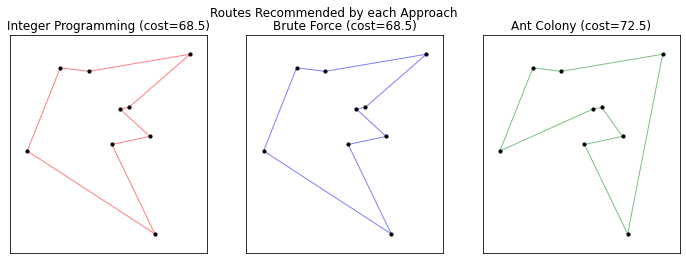

In [8]:
def route_comparison(routes, costs):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    pos = nx.kamada_kawai_layout(g)

    names = ["Integer Programming", "Brute Force", "Ant Colony"]
    colors = ["red", "blue", "green"]

    for route, name, route_cost, color, ax in zip(routes, names, costs, colors, axes):
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_title(f"{name} (cost={route_cost})")

        nx.draw_networkx_nodes(g, pos, ax=ax, node_size=10, node_color="black")
        nx.draw_networkx_edges(g, pos, ax=ax, edgelist=list(zip(route[:-1], route[1:])), edge_color=color, alpha=0.5)

    fig.suptitle("Routes Recommended by each Approach")

    plt.savefig("imgs/comparison.png")

routes = [ip_route, bf_route, ac_route]
costs = [ip_cost, bf_cost, ac_cost]
route_comparison(routes, costs)

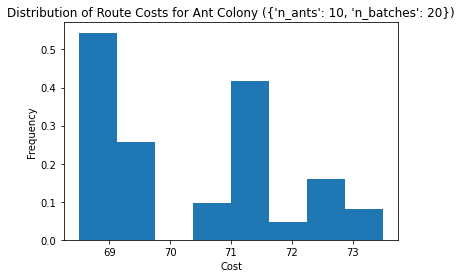

In [9]:
def ac_costs_hist(n_samples, **ac_params):
    costs = []

    for _ in range(n_samples):
        ac = AntColony(g=g, start=cafes[0], **ac_params)
        ac.run()
        costs.append(ac.best_cost)

    plt.hist(costs, density=True, bins=min(np.unique(costs).size, 8))
    plt.title(f"Distribution of Route Costs for Ant Colony ({dict(ac_params)})")
    plt.xlabel("Cost")
    plt.ylabel("Frequency")
    plt.savefig("imgs/ac_hist.png")

ac_costs_hist(100, n_ants=10, n_batches=20)